# Preliminary Operations
## Imports

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import argparse
# import sys
from pathlib import Path
import scipy.io as sio
import imageio
import cv2




from IPython.display import HTML, display
import tabulate
import os
import warnings

# sys.path.append('../..');
from spyrit.learning.model_Had_DCAN import *
from spyrit.learning.nets import *
from spyrit.misc.disp import *
from spyrit.misc.metrics import *
from spyrit.reconstruction.recon_functions import * 


torch.manual_seed(19)

In [2]:
from scipy.sparse.linalg import aslinearoperator
import pylops

def TV(y, H, img_size, mu = 0.15, lamda = [0.1, 0.1], niter = 20, niterinner = 10):
    ny = img_size;
    nx = img_size;
    A = aslinearoperator(H);
    H_p = pylops.LinearOperator(A)
    Dop = \
        [pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=0, edge=False,
                                kind='backward', dtype=np.float64),
         pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=1, edge=False,
                                kind='backward', dtype=np.float64)]
    xinv, niter = \
    pylops.optimization.sparsity.SplitBregman(H_p, Dop, y.flatten(),
                                              niter, niterinner,
                                              mu=mu, epsRL1s=lamda,
                                              tol=1e-4, tau=1., show=False,
                                              **dict(iter_lim=5, damp=1e-4))
    return xinv;

def batch_TV(m, batch_size, ch, img_size, H,N_0, mu = 0.15, lamda = [0.001, 0.001], niter = 3, niterinner = 3):
    outputs = np.zeros((batch_size*ch, 1, img_size, img_size));
    M = H.shape[0];
    even_indices = range(0,2*M,2);
    uneven_index = range(1,2*M,2);
    for i in range(batch_size*ch):
        m_i = torch2numpy(m[i,0,:]);
        m_i = m_i[even_indices]-m_i[uneven_index];
        out = TV(m_i, H, img_size, mu, lamda, niter, niterinner)
        outputs[i, 0, :,:] = 2/N_0*np.reshape(out, (img_size, img_size))-1;
    output_batch  = torch.Tensor(outputs);
    return output_batch;


In [3]:
def Inverse_square_root(A):
    """returns A^{-1/2}.
    Warning : This is only intended to be used if A is positive definite.
    """ 
    D, U = np.linalg.eig(A);
    D = 1/D;
    D = np.sqrt(D);
    A_inv = np.dot(np.dot(np.transpose(U), D), U);
    return diag(A_inv);


def diag(y):
    """
    Generates a diagonal matrix from vector y
    """ 
    n = y.shape[0];
    D = np.zeros((n,n));
    D[np.diag_indices(n)] = np.reshape(y,(n,));
    return D;

def Diag(A):
    """Extracts the diagonal elements of A"""
    a,b = A.shape;
    n = min(a,b);
    d = np.reshape(A[np.diag_indices(n)], (n,1));
    return d;


In [4]:
def Tikhonov_regularisation(H, y, x_0, P, R):
    """
    Solves the inverse problem 
    y = H x+ n ,
    by minimising 
    || Hx-y ||^2_{R^{-1}} + ||x - x_0||_{P^{-1}} , 
    where R is the noise covariance matrix, and P is the data covariance matrix.
    """
    Pat = np.dot(P, np.transpose(H));
    K = np.linalg.inv(R+np.dot(H,Pat));
    K_k = np.dot(Pat, K);
    x_out = x_0 + np.dot(K_k,y-np.dot(H,x_0));
    return x_out

def EM_TV(y, H, Sigma_a, img_size, Sigma_i, Sigma_1_2 = None, mu = 0.1, lamda = [1, 1], EM_N_iter = 4, niter = 3, niterinner = 3):
    """
    Solves the inverse problem 
    y = H x+ n ,
    by minimising 
    || Hx-y ||^2_{Sigma_a^{-1}} + lambda[0] ||D_1 x||_1 + lambda[1] ||D_2 x||_1
    where Sigma_a is the noise covariance matrix, where D_1 is the matrix corresponding to the first derivative over x and D_2 is the first derivative over y.
    This is done by applying the EM algorithm.
    """
    x_inv = np.zeros((img_size**2,1));
    if Sigma_1_2 is None:
        Sigma_1_2 = Inverse_square_root(Sigma_i);
    OP_TV = Sigma_1_2;
    for i in range(EM_N_iter):
        x_inv = np.reshape(x_inv, (img_size**2,1));
        # print(x_inv.shape)
        # print(y.shape)
        x_inv = Tikhonov_regularisation(H, y, x_inv, Sigma_i, Sigma_a);
        # print(x_inv.shape)
        # print(np.dot(Sigma_1_2, x_inv).shape)
        # print(OP_TV.shape)
        x_inv = TV(np.dot(Sigma_1_2, x_inv), OP_TV, img_size, mu=mu, lamda = lamda, niter = niter, niterinner=niterinner);
    return x_inv


def batch_EM_TV(m, batch_size, ch, img_size, H, N_0, Sigma_i, Sigma_1_2 = None, mu = 1, lamda = [1, 1], EM_N_iter = 4, niter = 3, niterinner = 3):
    """
    
    """
    outputs = np.zeros((batch_size*ch, 1, img_size, img_size));
    M = H.shape[0];
    One = np.dot(H, np.ones((img_size**2,1)))
    even_indices = range(0,2*M,2);
    uneven_index = range(1,2*M,2);
    for i in range(batch_size*ch):
        m_i = torch2numpy(m[i,0,:]);
        y_k_pos = m_i[even_indices];
        y_k_neg = m_i[uneven_index];
        
        y_k_pos = np.reshape(y_k_pos, (M,1));
        y_k_neg = np.reshape(y_k_neg, (M,1));
        
        Sigma_a = diag((y_k_pos+y_k_neg)/(N0**2));
        y_k = y_k_pos-y_k_neg;
        y_k = 2/N_0*y_k - One;
        out = EM_TV(y_k, H, Sigma_a, img_size, Sigma_i, Sigma_1_2 = Sigma_1_2, mu = mu, lamda = lamda, EM_N_iter = EM_N_iter, niter = niter, niterinner = niterinner);
        # outputs[i, 0, :,:] = np.reshape(2*(out-np.amin(out))/(np.amax(out)-np.amin(out))-1, (img_size, img_size));
        outputs[i, 0, :,:] = np.reshape(out, (img_size, img_size));
    output_batch  = torch.Tensor(outputs);
    return output_batch


In [5]:
import seaborn as sns

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def dico2boxplot(dico, color):
    Data = [dico[key] for key in dico];
    ticks = [str(key) for key in dico];
    plt.figure()
    for i in range(len(Data)):
        bpl = plt.boxplot(Data[i], positions = [i*2.0], sym="", widths=1.0, patch_artist=True)
        set_box_color(bpl, color[0])
        bpl["boxes"][0].set_facecolor(color[i+1])
        bpl["boxes"][0].set_linewidth(3)
        bpl["boxes"][0].set_linestyle("-")
        bpl["whiskers"][0].set_linewidth(3)
        bpl["whiskers"][0].set_linestyle("-")
        bpl["caps"][0].set_linewidth(3)
        bpl["caps"][0].set_linestyle("-")
        bpl["whiskers"][1].set_linewidth(3)
        bpl["whiskers"][1].set_linestyle("-")
        bpl["caps"][1].set_linewidth(3)
        bpl["caps"][1].set_linestyle("-")
        bpl["medians"][0].set_linewidth(3)
        bpl["medians"][0].set_linestyle("-")        
    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    
    
def set_violin_color(vp, color):
    for pc in vp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(0.3)

def dico2violinplot(dico, color):
    Data = [dico[key] for key in dico];
    ticks = [str(key) for key in dico];
    plt.figure()
    for i in range(len(Data)):
#         bpl = plt.violinplot(Data[i], positions = [i*2.0], widths=1.0, showmedians=  True, quantiles = [0.05, 0.95])
        bpl = plt.violinplot(Data[i], positions = [i*2.0], widths=1.0, showmedians=  True)
        set_violin_color(bpl, color[i])     
    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    


In [6]:
def list2latex(input_list, midrule_list, ncol):
    """Produces a latex table from a list.
    Inputs :
    * input_list : Python list. Each Element of input_list is a list of strings that 
        represents a line of the table we wish to display.
    * ncol : Integer. Defines the number of expected rows in the table.
    * midrule_list : list of integers that define the rows after which we put midrules. 
    """
    midrule_counter = 0;
    begin = "\\begin{tabular}{l"+(ncol-1)*"c"+"}";
    print(begin)
    print("\\toprule")
    for i in range(len(input_list)):
        print_line(input_list[i], ncol);
        if len(midrule_list)>midrule_counter:
            if midrule_list[midrule_counter]==i:
                print("\\midrule")
                midrule_counter+=1;
    print("\\bottomrule")
    print("\\end{tabular}")
    
    
    
def print_line(line, n_col):
    if len(line)>= n_col:
        string = ["{} & ".format(line[i]) for i in range(n_col)];
        string = ''.join(string)
        string = string[:-2]+"\\\\";
        print(string)
    else:
        string = ["{} & ".format(line[i]) for i in range(len(line)-1)];
        string = ''.join(string)
        string += "\multicolumn{"+str(n_col-len(line)+1)+"}{c}{"+ str(line[-1]) +"} \\\\";
        print(string)

## Parameters
### Acquisition Parameters

In [7]:
img_size = 64;

### Network and training

In [8]:
data_root = "../../data/" # Path to SLT-10 dataset
precompute_root ="../../models/SDCAN/"# Path to precomputed data
precompute =  False # Tells if the precomputed data is available 
n_iter = 5;

### Experimental Data

In [9]:
expe_root = "../../data/expe_2/" # Path to precomputed data

### Optimisation

In [10]:
num_epochs = 20 ; #Number of training epochs 
batch_size = 16; # Size of each training batch
reg = 1e-7; # Regularisation Parameter
lr = 1e-3; # Learning Rate
step_size = 4; #Scheduler Step Size
gamma =0.5; # Scheduler Decrease Rate

## Loading Pre-processed Data

In [11]:
my_average_file = Path(precompute_root) / ('Average_{}x{}'.format(img_size, img_size)+'.npy')
my_cov_file = Path(precompute_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.npy')

Path(precompute_root).mkdir(parents=True, exist_ok=True)
if not(my_average_file.is_file()) or not(my_cov_file.is_file()) or precompute:
    print('Computing covariance and mean (overwrite previous files)')
    Mean_had, Cov_had = Stat_had(trainloader, precompute_root)
else:
    print('Loading covariance and mean')
    Mean_had = np.load(my_average_file)
    Cov_had  = np.load(my_cov_file)

if expe_root:
    my_transform_file = Path(expe_root) / ('transform_{}x{}'.format(img_size, img_size)+'.mat')
    H = sio.loadmat(my_transform_file);
    H = (1/img_size)*H["H"]

    my_average_file = Path(expe_root) / ('Average_{}x{}'.format(img_size, img_size)+'.mat')
    my_cov_file = Path(expe_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.mat')
    Mean_had_1 = sio.loadmat(my_average_file)
    Cov_had_1  = sio.loadmat(my_cov_file)

    Mean_had_1 = Mean_had_1["mu"]-np.dot(H, np.ones((img_size**2,1)));
    Mean_had_1 = np.reshape(Mean_had_1,(img_size, img_size));
    Mean_had_1 = np.amax(Mean_had)/np.amax(Mean_had_1)*Mean_had_1;
    Cov_had_1 = Cov_had_1["C"];
    Cov_had_1 = np.amax(Cov_had)/np.amax(Cov_had_1)*Cov_had_1;
    Cov_had = Cov_had_1;
    Mean_had = Mean_had_1;

else :
    H = None;
    
Var = Cov2Var(Cov_had_1)
Perm = Permutation_Matrix(Var)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Loading covariance and mean


# STL-10
## Loading Dataset

In [12]:
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])


trainset = \
    torchvision.datasets.STL10(root= data_root, split='train+unlabeled',download=False, transform=transform)
trainloader = \
    torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=False)

testset = \
    torchvision.datasets.STL10(root = data_root, split='test',download=False, transform=transform)
testloader = \
    torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

dataloaders = {'train':trainloader, 'val':testloader}

## Simulated Data (CR = 7/8) 
### Parameters

In [13]:
CR = 512;
N0 = 10;
# sig = 0.5;
sig = 0;


# Pmat = np.dot(Perm,H);
# Pmat = img_size*Pmat[:CR,:];

H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];
Sigma_i = np.dot(np.transpose(H),np.dot(Cov_had,H))
# Sigma_1_2 = Inverse_square_root(Sigma_i);

### Loading Network

In [14]:
# net_arch = 2
# model_root = '../../models/TCI/Unet/'; #  Path to model saving files
# title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
# denoi_1 = Unet(1,1);
# model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
# model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_1 = model_1.to(device);
# load_net(title_1, model_1);
# model_1.eval()

In [15]:
# net_arch = 2
# model_root = '../../models/TCI/modl/'
# title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_512_epo_40_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
# denoi_2 = Unet(1,1);
# denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
# model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
# model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_2 = model_2.to(device);
# load_net(title_2, model_2);
# model_2.eval()

In [16]:
n_iter = 4;
# net_arch = 2;
# model_root = '../../models/TCI/neumann/'
# title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_512_epo_60_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-05"
# denoi_3 = Unet(1,1);
# denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
# model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
# model_3.recon.Gramian.weight.requires_grad = False;
# model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_3 = model_3.to(device);
# load_net(title_3, model_3);
# model_3.eval()

In [17]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_4 = model_root+"EM_net_unshared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_41_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_4 = DConvNet();
denoi_4 = EM_net_unshared(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
denoi_4.N0 = N0;
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/EM_net_unshared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_41_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): EM_net_unshared(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Pconv): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
    (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
    (denoise_list): ModuleList(
      (0): Denoise_layer(in_features=512)
      (1): Denoise_layer(in_features=512)
      (2): Denoise_layer(in_features=512)
      (3): Denoise_layer(in_features=512)
    )
    (conv): ModuleList(
      (0): DConvNet(
        (convnet): Sequential(
          (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
          (relu1): ReLU()
          (BN1): BatchNorm2d(64, eps=1e-05, momentum=0

In [18]:
# net_arch = 2
# model_root = '../../models/TCI/Unet/'; #  Path to model saving files
# title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
# denoi_5 = DConvNet();
# model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
# model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_5 = model_5.to(device);
# load_net(title_5, model_5);
# model_5.eval()

In [19]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_6 = model_root+"EM_net_shared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_41_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_6 = DConvNet();
denoi_6 = EM_net(CR, img_size, Cov_had,H, denoi_6, n_iter = n_iter)
denoi_6.N0 = N0;
model_6 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_6);
model_6.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_6 = model_6.to(device);
load_net(title_6, model_6);
model_6.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/EM_net_shared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_41_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): EM_net(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (c

### Compute Metrics Over the Test-set $N_0 = [2,5,10,50]$

In [20]:
# N0_list = [5, 10, 50, 2500];
N0_list = [2, 3, 5, 10, 50];
# N0_list = [2500];
title_list = ["GT", "EM Shared", "EM Unshared"]
torch.manual_seed(1)
Dico = {}

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    model_4.recon.N0 = N_0
    model_6.recon.N0 = N_0
    model_4.N0 = N_0;
    model_6.N0 = N_0;

    n_methods = 2;
    out_psnr = "data_review/psnr_{}_{}_stl_global.pkl".format(N_0, CR);
    out_ssim = "data_review/ssim_{}_{}_stl_global.pkl".format(N_0, CR);
    if os.path.isfile(out_psnr) and os.path.isfile(out_ssim):
        a_file = open(out_psnr, "rb")
        Dico_psnr = pickle.load(a_file)
        a_file.close()
        
        a_file = open(out_ssim, "rb")
        Dico_ssim = pickle.load(a_file)
        a_file.close()
        
    else :
        psnr_list = [[] for i in range(n_methods)];
        ssim_list = [[] for i in range(n_methods)];
        Dico_psnr = {};
        Dico_ssim = {};
        for batch, (inputs, labels) in enumerate(testloader):
            [batch_size, c, h, w] = inputs.shape;
            inputs = inputs.to(device);
            if batch*batch_size < 200:
                print("No = {}, batch = {} /{} ".format(N_0, batch, len(testloader)))
                with torch.no_grad():
                    m = model_4.forward_acquire(inputs ,batch_size, 1, img_size, img_size);

                    outputs = model_6.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[0]+= batch_psnr(inputs, outputs );
                    ssim_list[0]+= batch_ssim(inputs, outputs );
    
                    outputs = model_4.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[1]+= batch_psnr(inputs, outputs );
                    ssim_list[1]+= batch_ssim(inputs, outputs );
    

        psnr_list = [np.array(psnr_list[i]) for i in range(len(psnr_list))];
        ssim_list = [np.array(ssim_list[i]) for i in range(len(ssim_list))];
        

        Dico_psnr["EM Shared"] = psnr_list[0];
        Dico_psnr["EM Unshared"] = psnr_list[1];

        Dico_ssim["EM Shared"] = ssim_list[0];
        Dico_ssim["EM Unshared"] = ssim_list[1];
        
        
        a_file = open(out_psnr, "wb")
        pickle.dump(Dico_psnr, a_file)
        a_file.close()
        
        a_file = open(out_ssim, "wb")
        pickle.dump(Dico_ssim, a_file)
        a_file.close()
        
    Dico[N_0] = [Dico_psnr, Dico_ssim];


N0 = 2
No = 2, batch = 0 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 1 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 2 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 3 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 4 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 5 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 6 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 7 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 8 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 9 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 10 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 11 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 12 /500 
alpha in [2.00--2.00] photons
N0 = 3
No = 3, batch = 0 /500 
alpha in [3.00--3.00] photons
No = 3, batch = 1 /500 
alpha in [3.00--3.00] photons
No = 3, batch = 2 /500 
alpha in [3.00--3.00] photons
No = 3, batch = 3 /500 
alpha in [3.00--3.00] photons
No = 3, batch = 4 /500 
alpha in [3.00--3.00] photons
No = 3, bat

In [21]:
Table = [[r"$\alpha$", " "]+title_list[1:]];
for N_0 in N0_list :
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    
    psnr_mean = np.round([np.mean(psnr_list[i]) for i in range(len(psnr_list))],2);
    ssim_mean = np.round([np.mean(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    psnr_std = np.round([np.std(psnr_list[i]) for i in range(len(psnr_list))],2);
    ssim_std = np.round([np.std(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    Table.append(["{}".format(N_0), "PSNR"] + [r"${} \pm {}$".format(psnr_mean[i], psnr_std[i]) for i in range(len(psnr_mean))])
    Table.append(["{}".format(N_0), "SSIM"] + [r"${} \pm {}$".format(ssim_mean[i], ssim_std[i]) for i in range(len(ssim_mean))])

In [22]:
display(HTML(data="""
<style>
    div#notebook-container    {width: 100%;}
    div#menubar-container     {width: 100%;}
    div#maintoolbar-container {width: 100%;}
</style>
"""))
display(HTML(tabulate.tabulate(Table, tablefmt='html')))


$\alpha$,,EM Shared,EM Unshared
2,PSNR,$14.88 \pm 1.49$,$15.85 \pm 1.91$
2,SSIM,$0.73 \pm 0.15$,$0.77 \pm 0.14$
3,PSNR,$16.28 \pm 2.06$,$17.07 \pm 2.49$
3,SSIM,$0.8 \pm 0.13$,$0.83 \pm 0.11$
5,PSNR,$17.7 \pm 2.76$,$18.14 \pm 3.05$
5,SSIM,$0.87 \pm 0.11$,$0.88 \pm 0.09$
10,PSNR,$18.83 \pm 3.48$,$18.94 \pm 3.55$
10,SSIM,$0.91 \pm 0.07$,$0.92 \pm 0.06$
50,PSNR,$19.45 \pm 3.89$,$19.58 \pm 3.94$
50,SSIM,$0.93 \pm 0.05$,$0.94 \pm 0.06$


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


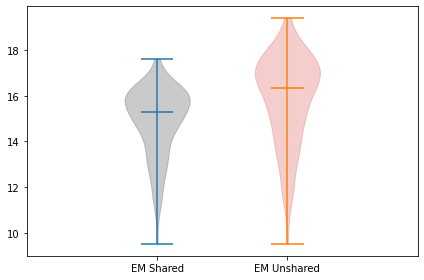

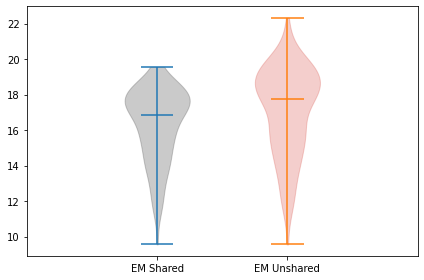

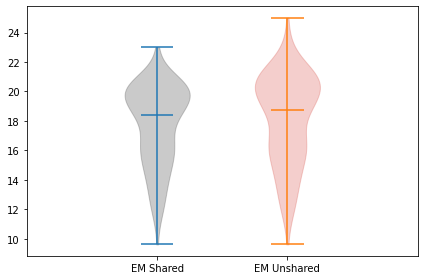

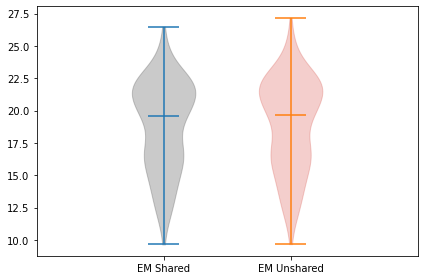

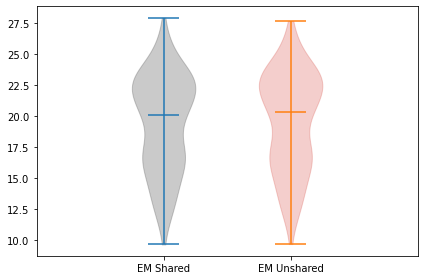

In [23]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = psnr_list[j];
    dico2violinplot(Dico_1, color)


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


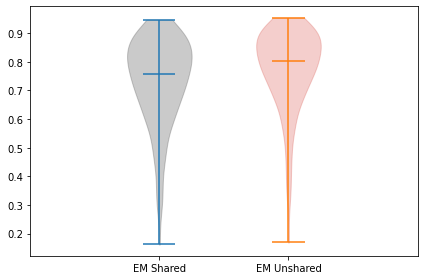

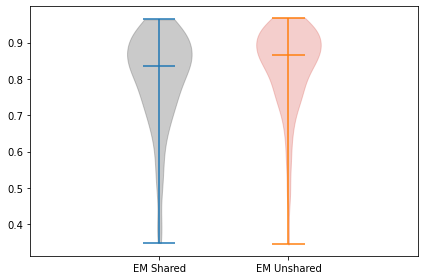

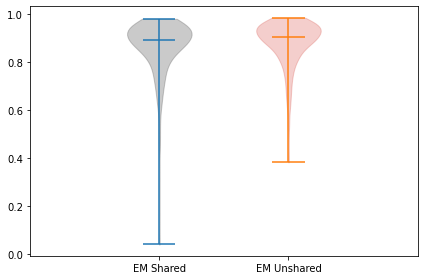

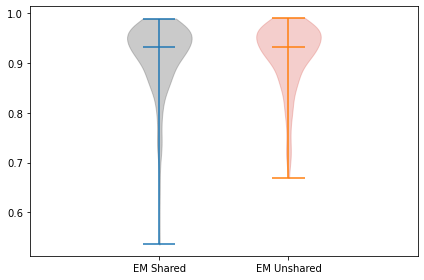

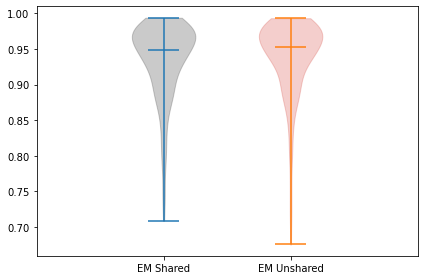

In [24]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = ssim_list[j];
    dico2violinplot(Dico_1, color)

## Simulated Data (CR = 3/4) 
### Parameters

In [25]:
CR = 1024;
N0 = 10;
sig = 0;

H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];
Sigma_i = np.dot(np.transpose(H),np.dot(Cov_had,H))
Sigma_1_2 = Inverse_square_root(Sigma_i);

### Loading Network

In [26]:
# net_arch = 2
# model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
# title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
# denoi_1 = Unet(1,1);
# model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
# model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_1 = model_1.to(device);
# load_net(title_1, model_1);
# model_1.eval()

In [27]:
# net_arch = 2
# model_root = '../../models/TCI/modl/'
# title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_1024_epo_30_lr_0.001_sss_7_sdr_0.5_bs_64_reg_1e-07"
# denoi_2 = Unet(1,1);
# denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
# model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
# model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_2 = model_2.to(device);
# load_net(title_2, model_2);
# model_2.eval()

In [28]:
n_iter = 4;
# net_arch = 2;
# model_root = '../../models/TCI/neumann/'
# title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_1024_epo_60_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
# denoi_3 = Unet(1,1);
# denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
# model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
# model_3.recon.Gramian.weight.requires_grad = False;
# model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_3 = model_3.to(device);
# load_net(title_3, model_3);
# model_3.eval()

In [29]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_4 = model_root+"EM_net_unshared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_31_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_4 = DConvNet();
denoi_4 = EM_net_unshared(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
denoi_4.N0 = N0;
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/EM_net_unshared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_31_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): EM_net_unshared(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Pconv): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
    (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
    (denoise_list): ModuleList(
      (0): Denoise_layer(in_features=1024)
      (1): Denoise_layer(in_features=1024)
      (2): Denoise_layer(in_features=1024)
      (3): Denoise_layer(in_features=1024)
    )
    (conv): ModuleList(
      (0): DConvNet(
        (convnet): Sequential(
          (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
          (relu1): ReLU()
          (BN1): BatchNorm2d(64, eps=1e-05, m

In [30]:
# net_arch = 2
# model_root = '../../models/TCI/Unet/'; #  Path to model saving files
# title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_1024_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
# denoi_5 = DConvNet();
# model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
# model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_5 = model_5.to(device);
# load_net(title_5, model_5);
# model_5.eval()

In [31]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_6 = model_root+"EM_net_shared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_31_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_6 = DConvNet();
denoi_6 = EM_net(CR, img_size, Cov_had,H, denoi_6, n_iter = n_iter)
denoi_6.N0 = N0;
model_6 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_6);
model_6.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_6 = model_6.to(device);
load_net(title_6, model_6);
model_6.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/EM_net_shared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_31_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): EM_net(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

### Compute Metrics Over the Test-set $N_0 = [2,5,10,50]$

In [32]:
# N0_list = [5, 10, 50, 2500];
N0_list = [2, 3, 5, 10, 50];
# N0_list = [2500];
title_list = ["GT", "EM Shared", "EM Unshared"]
torch.manual_seed(1)
Dico = {}

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    model_4.recon.N0 = N_0
    model_6.recon.N0 = N_0
    model_4.N0 = N_0;
    model_6.N0 = N_0;

    n_methods = 2;
    out_psnr = "data_review/psnr_{}_{}_stl_global.pkl".format(N_0, CR);
    out_ssim = "data_review/ssim_{}_{}_stl_global.pkl".format(N_0, CR);
    if os.path.isfile(out_psnr) and os.path.isfile(out_ssim):
        a_file = open(out_psnr, "rb")
        Dico_psnr = pickle.load(a_file)
        a_file.close()
        
        a_file = open(out_ssim, "rb")
        Dico_ssim = pickle.load(a_file)
        a_file.close()
        
    else :
        psnr_list = [[] for i in range(n_methods)];
        ssim_list = [[] for i in range(n_methods)];
        Dico_psnr = {};
        Dico_ssim = {};
        for batch, (inputs, labels) in enumerate(testloader):
            [batch_size, c, h, w] = inputs.shape;
            inputs = inputs.to(device);
            if batch*batch_size < 200:
                print("No = {}, batch = {} /{} ".format(N_0, batch, len(testloader)))
                with torch.no_grad():
                    m = model_4.forward_acquire(inputs ,batch_size, 1, img_size, img_size);

                    outputs = model_6.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[0]+= batch_psnr(inputs, outputs );
                    ssim_list[0]+= batch_ssim(inputs, outputs );
    
                    outputs = model_4.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[1]+= batch_psnr(inputs, outputs );
                    ssim_list[1]+= batch_ssim(inputs, outputs );
    

        psnr_list = [np.array(psnr_list[i]) for i in range(len(psnr_list))];
        ssim_list = [np.array(ssim_list[i]) for i in range(len(ssim_list))];
        

        Dico_psnr["EM Shared"] = psnr_list[0];
        Dico_psnr["EM Unshared"] = psnr_list[1];

        Dico_ssim["EM Shared"] = ssim_list[0];
        Dico_ssim["EM Unshared"] = ssim_list[1];
        
        
        a_file = open(out_psnr, "wb")
        pickle.dump(Dico_psnr, a_file)
        a_file.close()
        
        a_file = open(out_ssim, "wb")
        pickle.dump(Dico_ssim, a_file)
        a_file.close()
        
    Dico[N_0] = [Dico_psnr, Dico_ssim];


N0 = 2
No = 2, batch = 0 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 1 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 2 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 3 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 4 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 5 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 6 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 7 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 8 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 9 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 10 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 11 /500 
alpha in [2.00--2.00] photons
No = 2, batch = 12 /500 
alpha in [2.00--2.00] photons
N0 = 3
No = 3, batch = 0 /500 
alpha in [3.00--3.00] photons
No = 3, batch = 1 /500 
alpha in [3.00--3.00] photons
No = 3, batch = 2 /500 
alpha in [3.00--3.00] photons
No = 3, batch = 3 /500 
alpha in [3.00--3.00] photons
No = 3, batch = 4 /500 
alpha in [3.00--3.00] photons
No = 3, bat

In [33]:
Table = [[r"$\alpha$", " "]+title_list[1:]];
for N_0 in N0_list :
    
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    
    psnr_mean = np.round([np.mean(psnr_list[i]) for i in range(len(psnr_list))],2);
    ssim_mean = np.round([np.mean(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    psnr_std = np.round([np.std(psnr_list[i]) for i in range(len(psnr_list))],2);
    ssim_std = np.round([np.std(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    Table.append(["{}".format(N_0), "PSNR"] + [r"${} \pm {}$".format(psnr_mean[i], psnr_std[i]) for i in range(len(psnr_mean))])
    Table.append(["{}".format(N_0), "SSIM"] + [r"${} \pm {}$".format(ssim_mean[i], ssim_std[i]) for i in range(len(ssim_mean))])


In [34]:
display(HTML(data="""
<style>
    div#notebook-container    {width: 100%;}
    div#menubar-container     {width: 100%;}
    div#maintoolbar-container {width: 100%;}
</style>
"""))
display(HTML(tabulate.tabulate(Table, tablefmt='html')))


$\alpha$,,EM Shared,EM Unshared
2,PSNR,$14.25 \pm 1.25$,$14.66 \pm 1.42$
2,SSIM,$0.69 \pm 0.17$,$0.71 \pm 0.17$
3,PSNR,$15.82 \pm 1.8$,$16.39 \pm 2.1$
3,SSIM,$0.78 \pm 0.15$,$0.8 \pm 0.15$
5,PSNR,$17.61 \pm 2.68$,$18.11 \pm 3.01$
5,SSIM,$0.86 \pm 0.13$,$0.87 \pm 0.12$
10,PSNR,$19.07 \pm 3.57$,$19.21 \pm 3.67$
10,SSIM,$0.92 \pm 0.07$,$0.93 \pm 0.07$
50,PSNR,$19.8 \pm 4.08$,$19.86 \pm 4.07$
50,SSIM,$0.94 \pm 0.05$,$0.95 \pm 0.05$


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


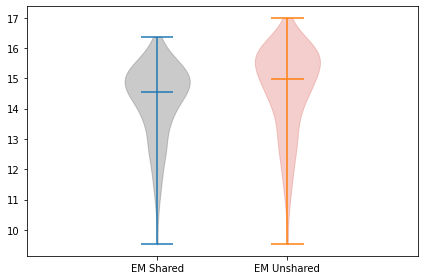

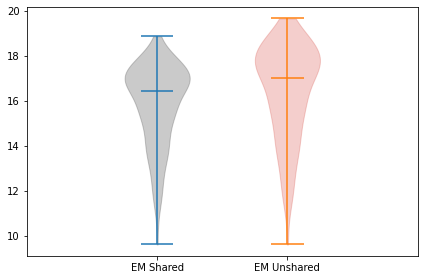

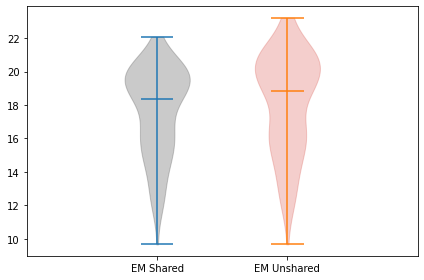

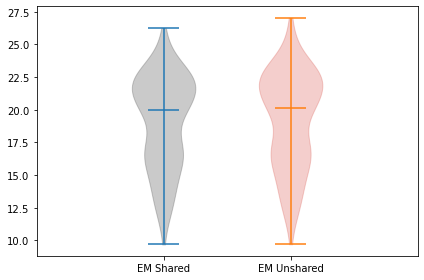

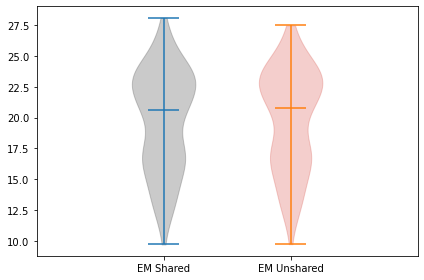

In [35]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = psnr_list[j];
    dico2violinplot(Dico_1, color)


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


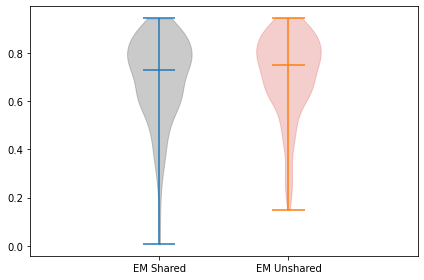

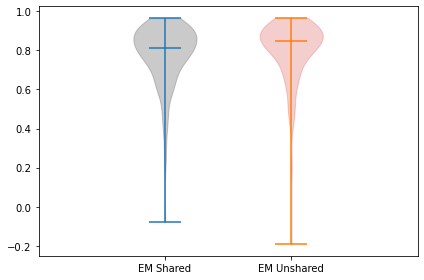

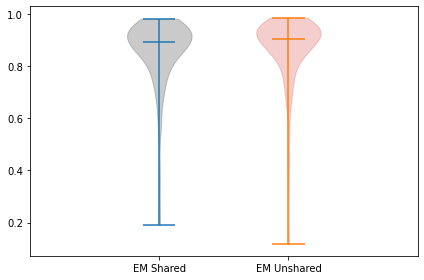

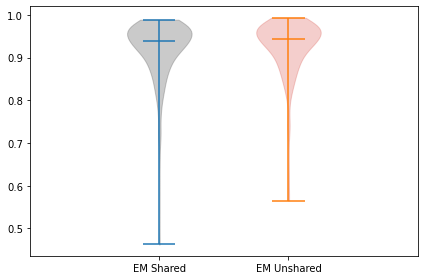

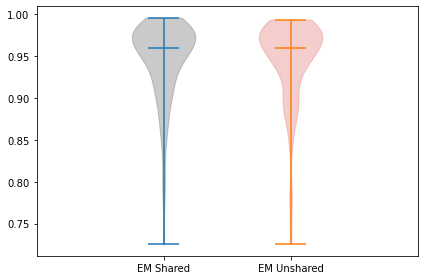

In [36]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = ssim_list[j];
    dico2violinplot(Dico_1, color)

## Imagenet

In [37]:
from spyrit.learning.imagenet_dataset import NetImage

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])



trainset = \
      NetImage(root=data_root, train = True, transform=transform)
trainloader = \
    torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=False)
testset = \
        NetImage(root=data_root, train = False, transform=transform)
testloader = \
     torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

dataloaders = {'train':trainloader, 'val':testloader}
num_img = {'train' : len(trainset), 'val' : len(testset)}

## Simulated Data (CR = 7/8) 
### Parameters

In [39]:
CR = 512;
N0 = 10;
sig = 0;

H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];
Sigma_i = np.dot(np.transpose(H),np.dot(Cov_had,H))
# Sigma_1_2 = Inverse_square_root(Sigma_i);

### Loading Network

In [40]:
# net_arch = 2
# model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
# title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_512_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
# denoi_1 = Unet(1,1);
# model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
# model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_1 = model_1.to(device);
# load_net(title_1, model_1);
# model_1.eval()

In [41]:
# net_arch = 2
# model_root = '../../models/TCI_imagenet/modl/'
# title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_512_epo_15_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
# denoi_2 = Unet(1,1);
# denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
# model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
# model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_2 = model_2.to(device);
# load_net(title_2, model_2);
# model_2.eval()

In [42]:
n_iter = 4;
# net_arch = 2;
# model_root = '../../models/TCI_imagenet/neumann/'
# title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_512_epo_20_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
# denoi_3 = Unet(1,1);
# denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
# model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
# model_3.recon.Gramian.weight.requires_grad = False; #was done during training script.
# model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_3 = model_3.to(device);
# load_net(title_3, model_3);
# model_3.eval()

In [43]:
net_arch = 0;
model_root = '../../models/TCI_imagenet/EM_net/'
title_4 = model_root+"EM_net_unshared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_4 = DConvNet();
denoi_4 = EM_net_unshared(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
denoi_4.N0 = N0;
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI_imagenet/EM_net/EM_net_unshared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): EM_net_unshared(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Pconv): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
    (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
    (denoise_list): ModuleList(
      (0): Denoise_layer(in_features=512)
      (1): Denoise_layer(in_features=512)
      (2): Denoise_layer(in_features=512)
      (3): Denoise_layer(in_features=512)
    )
    (conv): ModuleList(
      (0): DConvNet(
        (convnet): Sequential(
          (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
          (relu1): ReLU()
          (BN1): BatchNorm2d(64, eps=1e-05, momentum=0

In [44]:
# net_arch = 2
# model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
# title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_512_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
# model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
# model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_5 = model_5.to(device);
# load_net(title_5, model_5);
# model_5.eval()

In [45]:
net_arch = 0;
model_root = '../../models/TCI_imagenet/EM_net/'
title_6 = model_root+"EM_net_shared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_6 = DConvNet();
denoi_6 = EM_net(CR, img_size, Cov_had,H, denoi_6, n_iter = n_iter)
denoi_6.N0 = N0;
model_6 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_6);
model_6.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_6 = model_6.to(device);
load_net(title_6, model_6);
model_6.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI_imagenet/EM_net/EM_net_shared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): EM_net(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (c

### Compute Metrics Over the Test-set $N_0 = [2,5,10,50]$

In [46]:
# N0_list = [5, 10, 50, 2500];
N0_list = [2, 3, 5, 10, 50];
# N0_list = [2500];
title_list = ["GT", "EM Shared", "EM Unshared"]
torch.manual_seed(1)
Dico = {}

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    model_4.recon.N0 = N_0
    model_6.recon.N0 = N_0
    model_4.N0 = N_0;
    model_6.N0 = N_0;

    n_methods = 2;
    out_psnr = "data_review/psnr_{}_{}_imagenet_global.pkl".format(N_0, CR);
    out_ssim = "data_review/ssim_{}_{}_imagenet_global.pkl".format(N_0, CR);
    if os.path.isfile(out_psnr) and os.path.isfile(out_ssim):
        a_file = open(out_psnr, "rb")
        Dico_psnr = pickle.load(a_file)
        a_file.close()
        
        a_file = open(out_ssim, "rb")
        Dico_ssim = pickle.load(a_file)
        a_file.close()
        
    else :
        psnr_list = [[] for i in range(n_methods)];
        ssim_list = [[] for i in range(n_methods)];
        Dico_psnr = {};
        Dico_ssim = {};
        for batch, (inputs, labels) in enumerate(testloader):
            [batch_size, c, h, w] = inputs.shape;
            inputs = inputs.to(device);
            if batch*batch_size < 200:
                print("No = {}, batch = {} /{} ".format(N_0, batch, len(testloader)))
                with torch.no_grad():
                    m = model_4.forward_acquire(inputs ,batch_size, 1, img_size, img_size);

                    outputs = model_6.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[0]+= batch_psnr(inputs, outputs );
                    ssim_list[0]+= batch_ssim(inputs, outputs );
    
                    outputs = model_4.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[1]+= batch_psnr(inputs, outputs );
                    ssim_list[1]+= batch_ssim(inputs, outputs );
    

        psnr_list = [np.array(psnr_list[i]) for i in range(len(psnr_list))];
        ssim_list = [np.array(ssim_list[i]) for i in range(len(ssim_list))];
        

        Dico_psnr["EM Shared"] = psnr_list[0];
        Dico_psnr["EM Unshared"] = psnr_list[1];

        Dico_ssim["EM Shared"] = ssim_list[0];
        Dico_ssim["EM Unshared"] = ssim_list[1];
        
        
        a_file = open(out_psnr, "wb")
        pickle.dump(Dico_psnr, a_file)
        a_file.close()
        
        a_file = open(out_ssim, "wb")
        pickle.dump(Dico_ssim, a_file)
        a_file.close()
        
    Dico[N_0] = [Dico_psnr, Dico_ssim];


N0 = 2
No = 2, batch = 0 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 1 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 2 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 3 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 4 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 5 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 6 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 7 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 8 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 9 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 10 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 11 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 12 /3125 
alpha in [2.00--2.00] photons
N0 = 3
No = 3, batch = 0 /3125 
alpha in [3.00--3.00] photons
No = 3, batch = 1 /3125 
alpha in [3.00--3.00] photons
No = 3, batch = 2 /3125 
alpha in [3.00--3.00] photons
No = 3, batch = 3 /3125 
alpha in [3.00--3.00] photons
No = 3, batch = 4 /3125 
alpha in [3.00--3.00] p

In [47]:
Table = [[r"$\alpha$", " "]+title_list[1:]];
for N_0 in N0_list :
    
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    
    psnr_mean = np.round([np.mean(psnr_list[i]) for i in range(len(psnr_list))],2);
    ssim_mean = np.round([np.mean(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    psnr_std = np.round([np.std(psnr_list[i]) for i in range(len(psnr_list))],2);
    ssim_std = np.round([np.std(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    Table.append(["{}".format(N_0), "PSNR"] + [r"${} \pm {}$".format(psnr_mean[i], psnr_std[i]) for i in range(len(psnr_mean))])
    Table.append(["{}".format(N_0), "SSIM"] + [r"${} \pm {}$".format(ssim_mean[i], ssim_std[i]) for i in range(len(ssim_mean))])


In [48]:
display(HTML(data="""
<style>
    div#notebook-container    {width: 100%;}
    div#menubar-container     {width: 100%;}
    div#maintoolbar-container {width: 100%;}
</style>
"""))
display(HTML(tabulate.tabulate(Table, tablefmt='html')))


$\alpha$,,EM Shared,EM Unshared
2,PSNR,$14.37 \pm 1.93$,$15.12 \pm 2.32$
2,SSIM,$0.71 \pm 0.16$,$0.75 \pm 0.15$
3,PSNR,$15.53 \pm 2.47$,$16.12 \pm 2.86$
3,SSIM,$0.78 \pm 0.14$,$0.81 \pm 0.13$
5,PSNR,$16.72 \pm 3.2$,$17.02 \pm 3.46$
5,SSIM,$0.85 \pm 0.1$,$0.86 \pm 0.09$
10,PSNR,$17.6 \pm 3.85$,$17.67 \pm 3.9$
10,SSIM,$0.9 \pm 0.07$,$0.9 \pm 0.07$
50,PSNR,$18.08 \pm 4.22$,$18.22 \pm 4.29$
50,SSIM,$0.91 \pm 0.08$,$0.92 \pm 0.07$


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


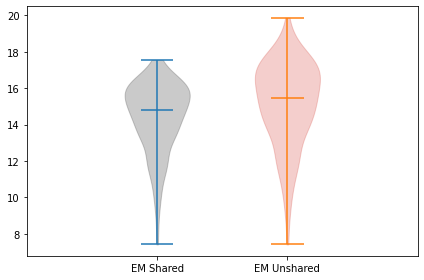

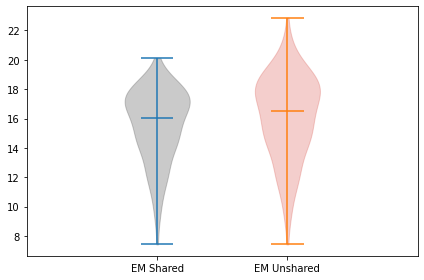

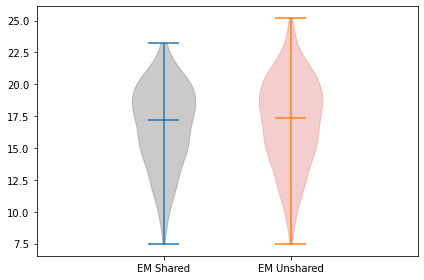

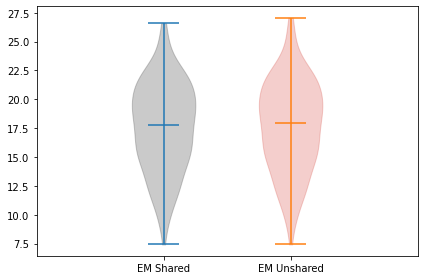

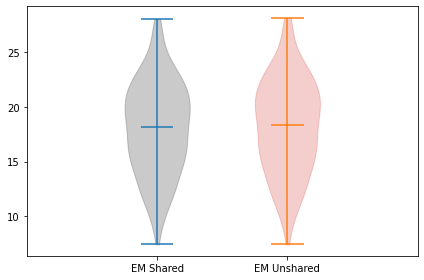

In [49]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = psnr_list[j];
    dico2violinplot(Dico_1, color)


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


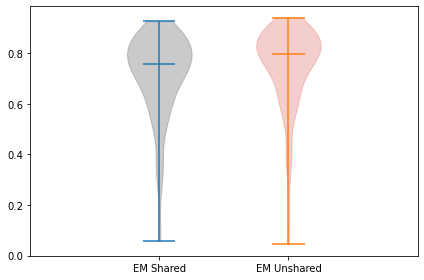

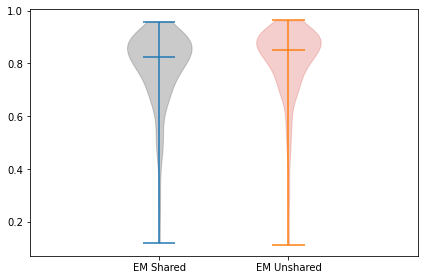

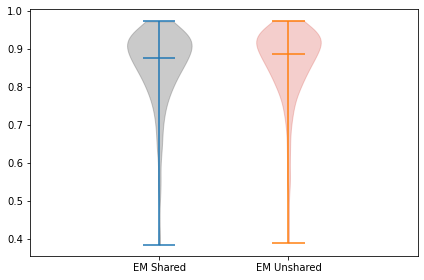

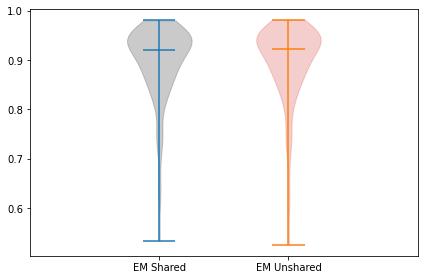

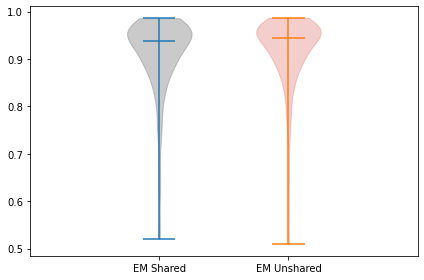

In [50]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = ssim_list[j];
    dico2violinplot(Dico_1, color)

## Simulated Data (CR = 3/4) 
### Parameters

In [51]:
CR = 1024;
N0 = 10;
sig = 0;


H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];
Sigma_i = np.dot(np.transpose(H),np.dot(Cov_had,H))
# Sigma_1_2 = Inverse_square_root(Sigma_i);

### Loading Network

In [52]:
# net_arch = 2
# model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
# title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
# denoi_1 = Unet(1,1);
# model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
# model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_1 = model_1.to(device);
# load_net(title_1, model_1);
# model_1.eval()

In [53]:
# net_arch = 2
# model_root = '../../models/TCI_imagenet/modl/'
# title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_1024_epo_10_lr_0.001_sss_3_sdr_0.5_bs_64_reg_1e-07"
# denoi_2 = Unet(1,1);
# denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
# model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
# model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_2 = model_2.to(device);
# load_net(title_2, model_2);
# model_2.eval()

In [54]:
n_iter = 4;
# net_arch = 2;
# model_root = '../../models/TCI_imagenet/neumann/'
# title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_1024_epo_15_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
# denoi_3 = Unet(1,1);
# denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
# model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
# model_3.recon.Gramian.weight.requires_grad = False; #was done during training script.
# model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_3 = model_3.to(device);
# load_net(title_3, model_3);
# model_3.eval()

In [55]:
net_arch = 0;
model_root = '../../models/TCI_imagenet/EM_net/'
title_4 = model_root+"EM_net_unshared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_4 = DConvNet();
denoi_4 = EM_net_unshared(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
denoi_4.N0 = N0;
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI_imagenet/EM_net/EM_net_unshared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


DenoiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): EM_net_unshared(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Pconv): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
    (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
    (denoise_list): ModuleList(
      (0): Denoise_layer(in_features=1024)
      (1): Denoise_layer(in_features=1024)
      (2): Denoise_layer(in_features=1024)
      (3): Denoise_layer(in_features=1024)
    )
    (conv): ModuleList(
      (0): DConvNet(
        (convnet): Sequential(
          (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
          (relu1): ReLU()
          (BN1): BatchNorm2d(64, eps=1e-05, m

In [56]:
# net_arch = 2
# model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
# title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
# model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
# model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_5 = model_5.to(device);
# load_net(title_5, model_5);
# model_5.eval()

In [57]:
# model_6 = model_4
net_arch = 0;
model_root = '../../models/TCI_imagenet/EM_net/'
title_6 = model_root+"EM_net_shared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_6 = DConvNet();
denoi_6 = EM_net(CR, img_size, Cov_had,H, denoi_6, n_iter = n_iter)
denoi_6.N0 = N0;
model_6 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_6);
model_6.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_6 = model_6.to(device);
load_net(title_6, model_6);
model_6.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI_imagenet/EM_net/EM_net_shared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


DenoiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): EM_net(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

### Compute Metrics Over the Test-set $N_0 = [2,5,10,50]$

In [58]:
# N0_list = [5, 10, 50, 2500];
N0_list = [2, 3, 5, 10, 50];
# N0_list = [2500];
title_list = ["GT", "EM Shared", "EM Unshared"]
torch.manual_seed(1)
Dico = {}

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    model_4.recon.N0 = N_0
    model_6.recon.N0 = N_0
    model_4.N0 = N_0;
    model_6.N0 = N_0;

    n_methods = 2;
    out_psnr = "data_review/psnr_{}_{}_imagenet_global.pkl".format(N_0, CR);
    out_ssim = "data_review/ssim_{}_{}_imagenet_global.pkl".format(N_0, CR);
    if os.path.isfile(out_psnr) and os.path.isfile(out_ssim):
        a_file = open(out_psnr, "rb")
        Dico_psnr = pickle.load(a_file)
        a_file.close()
        
        a_file = open(out_ssim, "rb")
        Dico_ssim = pickle.load(a_file)
        a_file.close()
        
    else :
        psnr_list = [[] for i in range(n_methods)];
        ssim_list = [[] for i in range(n_methods)];
        Dico_psnr = {};
        Dico_ssim = {};
        for batch, (inputs, labels) in enumerate(testloader):
            [batch_size, c, h, w] = inputs.shape;
            inputs = inputs.to(device);
            if batch*batch_size < 200:
                print("No = {}, batch = {} /{} ".format(N_0, batch, len(testloader)))
                with torch.no_grad():
                    m = model_4.forward_acquire(inputs ,batch_size, 1, img_size, img_size);

                    outputs = model_6.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[0]+= batch_psnr(inputs, outputs );
                    ssim_list[0]+= batch_ssim(inputs, outputs );
    
                    outputs = model_4.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[1]+= batch_psnr(inputs, outputs );
                    ssim_list[1]+= batch_ssim(inputs, outputs );
    

        psnr_list = [np.array(psnr_list[i]) for i in range(len(psnr_list))];
        ssim_list = [np.array(ssim_list[i]) for i in range(len(ssim_list))];
        

        Dico_psnr["EM Shared"] = psnr_list[0];
        Dico_psnr["EM Unshared"] = psnr_list[1];

        Dico_ssim["EM Shared"] = ssim_list[0];
        Dico_ssim["EM Unshared"] = ssim_list[1];
        
        
        a_file = open(out_psnr, "wb")
        pickle.dump(Dico_psnr, a_file)
        a_file.close()
        
        a_file = open(out_ssim, "wb")
        pickle.dump(Dico_ssim, a_file)
        a_file.close()
        
    Dico[N_0] = [Dico_psnr, Dico_ssim];


N0 = 2
No = 2, batch = 0 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 1 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 2 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 3 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 4 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 5 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 6 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 7 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 8 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 9 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 10 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 11 /3125 
alpha in [2.00--2.00] photons
No = 2, batch = 12 /3125 
alpha in [2.00--2.00] photons
N0 = 3
No = 3, batch = 0 /3125 
alpha in [3.00--3.00] photons
No = 3, batch = 1 /3125 
alpha in [3.00--3.00] photons
No = 3, batch = 2 /3125 
alpha in [3.00--3.00] photons
No = 3, batch = 3 /3125 
alpha in [3.00--3.00] photons
No = 3, batch = 4 /3125 
alpha in [3.00--3.00] p

In [59]:
Table = [[r"$\alpha$", " "]+title_list[1:]];
for N_0 in N0_list :
    
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    
    psnr_mean = np.round([np.mean(psnr_list[i]) for i in range(len(psnr_list))],2);
    ssim_mean = np.round([np.mean(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    psnr_std = np.round([np.std(psnr_list[i]) for i in range(len(psnr_list))],2);
    ssim_std = np.round([np.std(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    Table.append(["{}".format(N_0), "PSNR"] + [r"${} \pm {}$".format(psnr_mean[i], psnr_std[i]) for i in range(len(psnr_mean))])
    Table.append(["{}".format(N_0), "SSIM"] + [r"${} \pm {}$".format(ssim_mean[i], ssim_std[i]) for i in range(len(ssim_mean))])


In [60]:
display(HTML(data="""
<style>
    div#notebook-container    {width: 100%;}
    div#menubar-container     {width: 100%;}
    div#maintoolbar-container {width: 100%;}
</style>
"""))
display(HTML(tabulate.tabulate(Table, tablefmt='html')))


$\alpha$,,EM Shared,EM Unshared
2,PSNR,$14.04 \pm 1.78$,$13.97 \pm 1.7$
2,SSIM,$0.69 \pm 0.17$,$0.69 \pm 0.17$
3,PSNR,$15.58 \pm 2.49$,$15.27 \pm 2.28$
3,SSIM,$0.79 \pm 0.14$,$0.77 \pm 0.15$
5,PSNR,$17.03 \pm 3.39$,$16.72 \pm 3.12$
5,SSIM,$0.87 \pm 0.1$,$0.85 \pm 0.11$
10,PSNR,$17.95 \pm 4.04$,$17.87 \pm 3.97$
10,SSIM,$0.91 \pm 0.07$,$0.91 \pm 0.07$
50,PSNR,$18.45 \pm 4.35$,$18.42 \pm 4.41$
50,SSIM,$0.93 \pm 0.06$,$0.93 \pm 0.07$


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


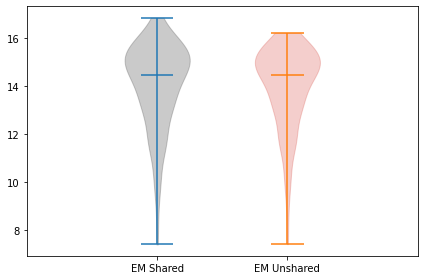

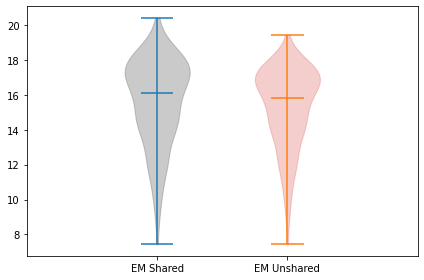

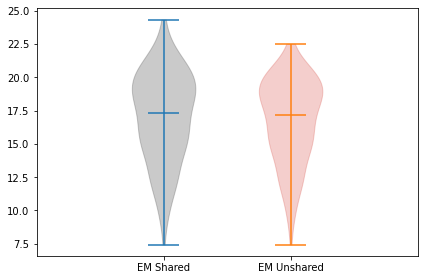

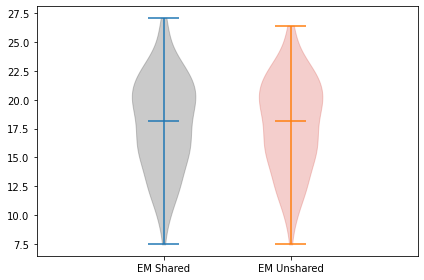

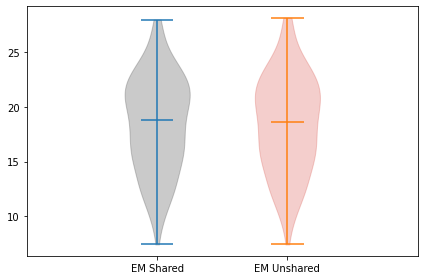

In [61]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = psnr_list[j];
    dico2violinplot(Dico_1, color)


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


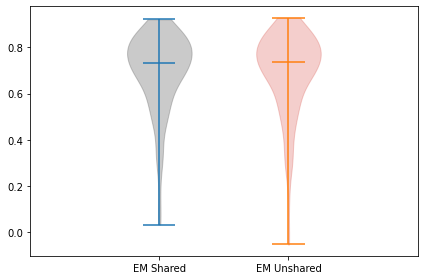

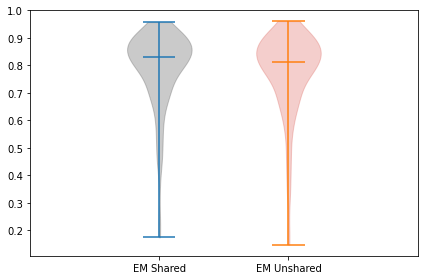

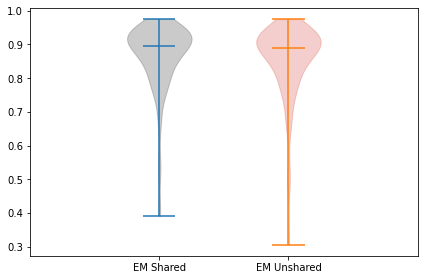

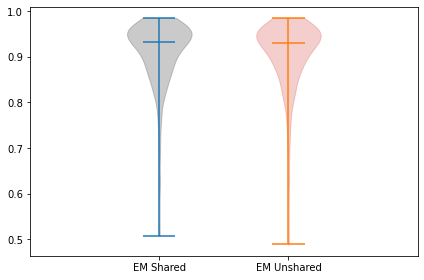

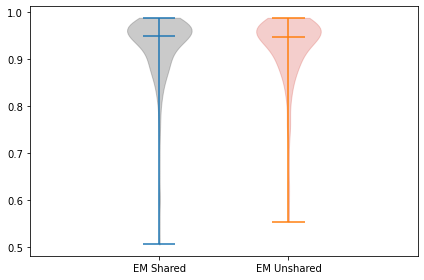

In [62]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = ssim_list[j];
    dico2violinplot(Dico_1, color)